In [1]:
# multigrid methods
# Overrelaxation (finding the coefficients is the difficult part)
# Do first in cartesian (spherical is lots more work)

## PHYS 481 Midterm

November 11, 2018

Kenneth Sharman (00300185)

In [2]:
'''Import standard packages'''
import numpy as np
import matplotlib.pyplot as plt


### Introduction

BLAH BLAH BLAH

Many important and interesting phenomena are modelled by functions of several variables that satisfy certain _partial differential equations_. These equations can be divided into initial value problems and boundary value problems. We will study the equation known as __Laplace's Equation__, which is a boundary value problem. A classic example of Laplace's equation is the problem of solving for the electric potential in electrostatics.

__Electrostatics__

Consider two of the most important equations in electrostatics. The electric field $\vec{E}$ and the electrostatic potential $V$ are related by $\vec{E} = - \vec{\nabla} V $. The differential form of Gauss's Law relates the volume charge density $\rho$ $ \big[ \frac{C}{m^3} \big]$ and the electric field by $\vec{\nabla} \cdot \vec{E} = \frac{\rho}{\epsilon_0}$, where $\epsilon_0$ is the electric permittivity of free space ($\epsilon_0 = 8.85 \times 10^{-12}\; C/Vm$).

In the absence of any electric charges we have $\vec{\nabla} \cdot \vec{E} = 0 \Rightarrow - \vec{\nabla} \cdot \vec{\nabla} V $. Expressing this in terms of the Laplace operator, or the full cartesian partial derivatives,

$$ \nabla^2 V = 0 \qquad \Longleftrightarrow \qquad \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} +  \frac{\partial^2 V}{\partial z^2} = 0 $$

which are the classic representations of Laplace's equation. The beauty and simplicity of Laplace's equation in electrostatics is found in the _Uniqueness Theorem_ which states that the solution to Laplace's equation in some volume $\Omega$ is uniquely determined if $V$ is specified on the boundary surface $\text{S}$. Thus, we can be assured that if a solution is found that is consistent with the imposed boundary conditions, we need not go any further, as this is the one and only solution to our problem.

When we studied this topic in electromagnetism, we began with the one-dimensional case and worked our way up to higher dimensions. We will use the same process in this analysis.

__Task 1: Laplace 1D__

To begin, consider a system that independent of the cartesian $y$ and $z$ coordinates. The partial differential equation is dependent only on $x$ and assumes the form

$$  \frac{\partial^2 V}{\partial x^2} = 0 $$

Next, assume that the potential is known to have the following values at the boundary points

$$V(0) = 0 \qquad \text{and} \qquad V(1) = 1 $$

Solutions to Laplace's equation are known as harmonic functions. These functions have no local maxima or minima. In PHYS 455 we learned that this is equivalent to stating that $V(x)$ is the average of $V(x+a)$ and $V(x-a)$ for any $a$:

$$ V(x) = \frac{1}{2} \Big[ V(x+a) + V(x-a) \Big] $$

This result is a direction consequence of the method of finite differences, which approximates the value of a nth-order derivative using the Taylor Series expansion of that function.

To determine the solutionm, we will use __The Relaxation Method__, which simply iterates the average value function. An initial guess is made of the unknown variable $V(x)$, then this value is plugged into the right-hand side of the equation to get a new value for $V(x)$. The process is repeated until $V(x)$ settles down to some fixed value. It has been proved$^1$ that this approach for solving the Laplace equation, also known as the __Jacobi Method__, is numerically stable and always gives a solution.

We will setup a one-dimensional array, representing the points of our system, initialize the endpoints with the given boundary conditions, and iterate the relaxation method until the potential at each point stops changing within some limit of tolerance. To implement this in code, a class will be defined with the appropriate attributes.

In [3]:
'''Implement class for case of 1D Laplace Equation'''
class ElectricPotential1D:
    '''
    Class represents a 1D electrostatic system, where interior points are found by
    solving Laplace's equation using the method of relaxation.
    '''
    def __init__(self, left_point, right_point, left_bound_val, right_bound_val, grid_size, tol):
        '''
        Constructor initializes all instances variables and sets boundary conditions
        Parameters:
            left_point, right_point: x location for left and right boundaries (SI units: m)
            left_bound_val, right_bound_val: Electruic potential at boundaries (SI units: V)
            grid_size: Size of 1D array
            tol: Tolerance required to terminate relaxation method
        '''
        self.x_vals = np.linspace(left_point, right_point, grid_size) # array of x values
        self.v_vals = np.zeros(grid_size) # initial guess of V values
        self.target = tol # Relaxation tolerance limit

        # Set boundary conditions
        self.__init__set_boundary_conditions(left_bound_val, right_bound_val)

    def __init__set_boundary_conditions(self, left_bound_val, right_bound_val):
        '''
        Initializes the boundary conditions specified during instantiation
        Parameters:
            left_bound_val, right_bound_val: Electruic potential at boundaries (SI units: V)
        '''
        self.v_vals[0] = left_bound_val # V[0] = left boundary conditions
        self.v_vals[-1] = right_bound_val # V[1] = right boundary condition

    def iterate_relaxation(self, plot=False):
        '''
        Iterates the relaxation method until solution varies by less than target tolerance
        Parameters:
            plot: if True solution and iteration count are added to a return list every 1000
            iterations. Default is False
        Returns:
            if plot==False: numbers of iterations required for specified target tolerance
            else: solution and count number after every 1000 iterations
        '''
        count, delta, return_list = 0, 1.0, [] # Initialize variables used in while loop
        v_prime = np.empty(len(self.v_vals)) # Empty list for relaxation method solution

        # Loop calculates the average value of both neighbors for every point. The boundary
        # points are set to boundary values. The (new) calculated solution becomes the (old)
        # solution in the next iteration by swapping array values after calculation is complete
        # The max difference in new and old solutions is compared against target tolerance.
        # Loop is broken when this difference is less than target.
        while True:
            v_prime[0], v_prime[-1] = self.v_vals[0], self.v_vals[-1] # set boundary vals
            v_prime[1:-1] = (self.v_vals[0:-2] + self.v_vals[2:]) / 2.0 # avg of neighbors
            self.v_vals, v_prime = v_prime, self.v_vals # Swap new and old values
            delta = max(abs(self.v_vals - v_prime)) # max difference for all points

            # For every 1000 iterations add solution and iteration number to return list
            if (count % (1000) == 0) and plot == True:
                return_list.append([np.copy(self.v_vals), count])

            count += 1
            if delta < self.target: break # Break loop when target tol is achieved

        return return_list if plot == True else count


To verify that the code is working as intended we will run a simple test. Suppose we have a one-dimensional system with boundary values of $V(0)=10$ and $V(5)=10$. Since Laplace's equation tolerates no local maxima or minima, we expect the solution to simply be $V(x)=10$. The following defines a test function that determines if the ElectricPotential_1D class is consistent with this expected solution.

In [4]:
'''Simple Test of ElectricPotential_1D class'''
def test_electric_potential_onedim():
    '''Assertion check of difference between computed and analytical solutions'''
    test_system = ElectricPotential1D(0.0, 5.0, 10.0, 10.0, 101, 1e-5)
    test_system.iterate_relaxation()
    expected = [10.0]*len(test_system.v_vals)
    assert max(abs(test_system.v_vals - expected)) < 0.02

test_electric_potential_onedim()


It was found that our system is consistent with expectations, to within 0.02, given that the relaxation method terminated after the solutions were varying less than 1e-5 between iterations. I had to change the assertion tolerance (actually had to print out the maximum difference) to determine exactly what was going on, as I had initially mistaken the relaxation tolerance to be the accuracy of the solution. This test demonstrated that indeed the class is consistent with expectations, but it has also highlighted the issue of determining how accurate these solutions are.

The analytic solution to Task 1 is easily obtained so we can compare it with the solutions obtained after a certain number of iterations, to get an idea of the error involved. Determining the analytic solution,

$$  \frac{\partial^2 V}{\partial x^2} = 0 \qquad\Longrightarrow\qquad \frac{\partial V}{\partial x} = constant $$

$$ \therefore \qquad V(x) = ax + b \qquad \text{where a and b are constants} $$

$$ V(0) = a(0) + b = 0 \qquad \therefore \qquad b = 0 $$

$$ V(1) = a(1) + 0 = 1 \qquad \therefore \qquad a = 1 $$

$$ V(x) = x $$

The solutions generated after various relaxation iterations will be plotted along with a plot of the corresponding errors involved.

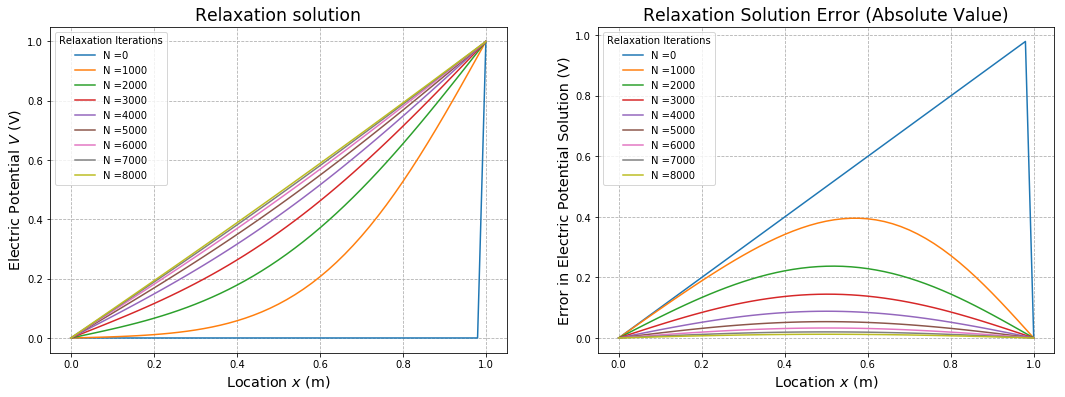

In [5]:
'''Plot Relaxation Solutions and Corresponding Errors'''
# Instantiate the 1D system
one_dim_system = ElectricPotential1D(0.0, 1.0, 0.0, 1.0, 101, 1e-5)
nstep_solns = one_dim_system.iterate_relaxation(True) # Store solns/ counts

plt.figure(figsize=(18, 6)) # Set the plot size
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2) # Create 2 subplots

# Plot solutions and errors in solutions
for soln in nstep_solns:
    ax1.plot(one_dim_system.x_vals, soln[0], label='N =' + str(soln[1]))
    ax2.plot(one_dim_system.x_vals, abs(soln[0]-one_dim_system.x_vals), label='N =' + str(soln[1]))

# Customize first subplot
ax1.legend(title='Relaxation Iterations')
ax1.set_xlabel('Location $x$ (m)', fontsize='x-large')
ax1.set_ylabel('Electric Potential $V$ (V)', fontsize='x-large')
ax1.set_title('Relaxation solution', fontsize='xx-large')
ax1.grid(linestyle='dashed') # Add grid with dashed lines to graph

# Customize second subplot
ax2.legend(title='Relaxation Iterations')
ax2.set_xlabel('Location $x$ (m)', fontsize='x-large')
ax2.set_ylabel('Error in Electric Potential Solution (V)', fontsize='x-large')
ax2.set_title('Relaxation Solution Error (Absolute Value)', fontsize='xx-large')
ax2.grid(linestyle='dashed') # Add grid with dashed lines to graph

plt.show()


It comes as no surprise that the error associated with a solution is reduced for an increased number of iterations of the relaxation method. From the solution plot; it is clear that a large number of iterations are required for the interior points to converge to the known solution. We should then, select the largest number of iterations possible. This value is dependent on how much time we can allocate to this computation.

Recall that the relaxation method terminates when the solutions after each iteration no longer vary by a desired tolerance. We can investigate the runtime complexity by plotting both the number of iterations and the runtime required to obtained the given tolerance. 

In [6]:
'''Calculate Number of Iterations Required for Relaxation Tolerances'''
TOLERANCES = np.geomspace(1e-10, 1, num=11) # Array of relaxation tolerances
iteration_counts = [] # List for iterations required to obtain soln within tolerance

# For each tolerance, add the number of iterations required to a list used for plotting
for tol in TOLERANCES:
    elecstatic_system = ElectricPotential1D(0.0, 1.0, 0.0, 1.0, 101, tol)
    iteration_counts.append(elecstatic_system.iterate_relaxation())


In [7]:
'''Evaluate Runtimes Required for Relaxation Tolerances'''
import timeit #Import timeit package to evaluate runtimes

run_times = [] # Lists for average runtimes

# For each tolerance, determine add runtime required to a list used for plotting
for tol in TOLERANCES:
    elecstatic_system = ElectricPotential1D(0.0, 1.0, 0.0, 1.0, 101, tol)
    run_times.append(timeit.timeit(elecstatic_system.iterate_relaxation, number=1000))


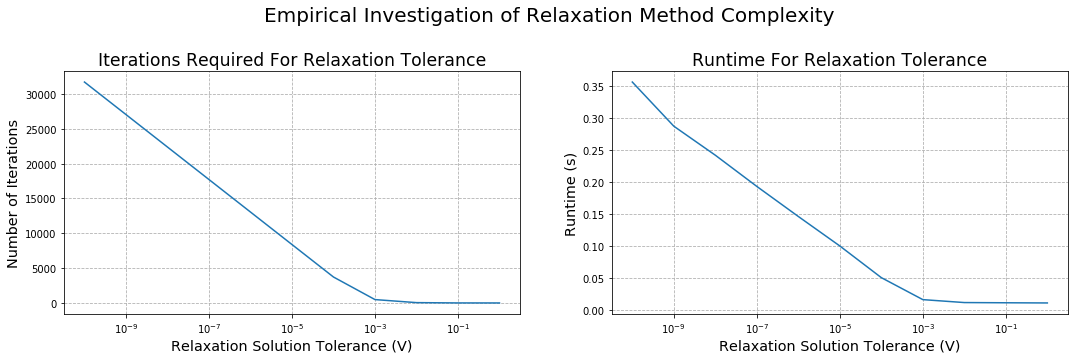

In [8]:
'''Plot Iterations and Runtimes Required for Relaxation Tolerances'''
plt.figure(figsize=(18, 5)) # Set the plot size
# Add super-title to both subplots
plt.suptitle('Empirical Investigation of Relaxation Method Complexity', fontsize=20)
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2) # Create 2 subplots

# Plot iterations required for relaxation tolerances
ax1.plot(TOLERANCES, iteration_counts)
ax1.set_xscale('log') # Semi log scale
ax1.set_xlabel('Relaxation Solution Tolerance (V)', fontsize='x-large')
ax1.set_ylabel('Number of Iterations', fontsize='x-large')
ax1.set_title('Iterations Required For Relaxation Tolerance', fontsize='xx-large')
ax1.grid(linestyle='dashed') # Add grid with dashed lines to graph

# Plot runtime required for relaxation tolerances
ax2.plot(TOLERANCES, run_times)
ax2.set_xscale('log') # Semi log scale
ax2.set_xlabel('Relaxation Solution Tolerance (V)', fontsize='x-large')
ax2.set_ylabel('Runtime (s)', fontsize='x-large')
ax2.set_title('Runtime For Relaxation Tolerance', fontsize='xx-large')
ax2.grid(linestyle='dashed') # Add grid with dashed lines to graph

plt.subplots_adjust(top=0.80)
plt.show()


It may not come as a surprise that both plots have a very similar shape. This highlights the fact that the iterative method is quite impractical if solutions are required to a high degree of accuracy; there is no hope that the algorithm will perform any better as the tolerance is decreased.

Since these are semi log plots, we note that past roughly three decimal places, the algorithms' complexity increases exponentially as the tolerance is decreased. The relaxation method is extremely simple to implement, and solutions converge relatively quickly for one or two decimal places, however a faster method would usually be necessary if higher degrees of accuracy were required.

### References

[1] http://www.cs.unipr.it/~bagnara/Papers/PDF/SIREV95.pdf